In [ ]:
# ====== Cell 1: Imports, Device, Early Stopping ======
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.counter = 0
        self.should_stop = False

    def step(self, val_loss):
        if self.best is None:
            self.best = val_loss
            self.counter = 0
            return False

        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.should_stop = True
        return self.should_stop


Using device: cpu


In [4]:
from torchvision import datasets, transforms

dataset_name = "FashionMNIST"  # or "MNIST"

if dataset_name == "MNIST":
    DatasetClass = datasets.MNIST
elif dataset_name == "FashionMNIST":
    DatasetClass = datasets.FashionMNIST
else:
    raise ValueError("Unsupported dataset for this block")

transform = transforms.Compose([
    transforms.ToTensor()
])

train_full = DatasetClass(root="./data", train=True, transform=transform, download=True)
test_full  = DatasetClass(root="./data", train=False, transform=transform, download=True)

train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_dataset, val_dataset = random_split(train_full, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_full, batch_size=128, shuffle=False)


100%|██████████| 26.4M/26.4M [00:10<00:00, 2.58MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.21MB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.50MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.06MB/s]


In [ ]:
# ====== Cell 2: Dataset loader for MNIST / FashionMNIST ======
dataset_name = "FashionMNIST"  # or "MNIST"

if dataset_name == "MNIST":
    DatasetClass = datasets.MNIST
elif dataset_name == "FashionMNIST":
    DatasetClass = datasets.FashionMNIST
else:
    raise ValueError("Unsupported dataset")

transform = transforms.Compose([
    transforms.ToTensor()
])

train_full = DatasetClass(root="./data", train=True, transform=transform, download=True)
test_full  = DatasetClass(root="./data", train=False, transform=transform, download=True)

train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_dataset, val_dataset = random_split(train_full, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_full, batch_size=128, shuffle=False)

print(f"{dataset_name} -> Train: {len(train_dataset)}  Val: {len(val_dataset)}  Test: {len(test_full)}")


Train: 48000  Val: 12000  Test: 10000


In [ ]:
# ====== Cell 3: β-VAE for 28x28 grayscale (latent 32) ======
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: 784 -> 512
        self.fc_enc = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU()
        )
        self.fc_mu     = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        # Decoder: 32 -> 512 -> 784
        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        B = x.size(0)
        x_flat = x.view(B, -1)
        h = self.fc_enc(x_flat)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        B = z.size(0)
        out = self.fc_dec(z)
        out = out.view(B, 1, 28, 28)
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

model = BetaVAE(latent_dim=32).to(device)
print(model)


BetaVAE(
  (fc_enc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=32, bias=True)
  (fc_dec): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [ ]:
# ====== Cell 4: β-VAE loss and optimizer ======
beta = 1.0  # you can experiment with 0.5 etc.

def beta_vae_loss(recon_x, x, mu, logvar, beta=1.0):
    B = x.size(0)
    # sum over all pixels, mean over batch
    recon_loss = F.mse_loss(recon_x, x, reduction="sum") / B
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    kl_loss = torch.mean(kl)
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss.detach().item(), kl_loss.detach().item()

optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# ====== Cell 5: Training Loop with Early Stopping ======
num_epochs = 50  # can be higher now, early stopping will cut it
early_stopping = EarlyStopping(patience=5, min_delta=1e-4)

train_total_losses = []
val_total_losses   = []

train_recon_losses = []
train_kl_losses    = []

val_recon_losses = []
val_kl_losses    = []

for epoch in range(num_epochs):
    # linear warmup of β from 0 -> 1 over first 10 epochs
    beta_current = beta * min(1.0, (epoch + 1) / 10.0)

    # ----- TRAIN -----
    model.train()
    running_total = 0.0
    running_recon = 0.0
    running_kl    = 0.0

    for images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
        images = images.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(images)
        total_loss, recon_loss_val, kl_loss_val = beta_vae_loss(
            recon, images, mu, logvar, beta=beta_current
        )
        total_loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        running_total += total_loss.item() * batch_size
        running_recon += recon_loss_val * batch_size
        running_kl    += kl_loss_val * batch_size

    # compute epoch train losses
    train_total = running_total / len(train_loader.dataset)
    train_recon = running_recon / len(train_loader.dataset)
    train_kl    = running_kl / len(train_loader.dataset)

    train_total_losses.append(train_total)
    train_recon_losses.append(train_recon)
    train_kl_losses.append(train_kl)

    # ----- VALIDATION -----
    model.eval()
    running_total = 0.0
    running_recon = 0.0
    running_kl    = 0.0

    with torch.no_grad():
        for images, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val"):
            images = images.to(device)
            recon, mu, logvar = model(images)
            total_loss, recon_loss_val, kl_loss_val = beta_vae_loss(
                recon, images, mu, logvar, beta=beta_current
            )

            batch_size = images.size(0)
            running_total += total_loss.item() * batch_size
            running_recon += recon_loss_val * batch_size
            running_kl    += kl_loss_val * batch_size

    val_total = running_total / len(val_loader.dataset)
    val_recon = running_recon / len(val_loader.dataset)
    val_kl    = running_kl / len(val_loader.dataset)

    val_total_losses.append(val_total)
    val_recon_losses.append(val_recon)
    val_kl_losses.append(val_kl)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Total: {train_total:.4f}  Val Total: {val_total:.4f}  "
          f"(Train recon: {train_recon:.4f}, KL: {train_kl:.4f}, "
          f"beta: {beta_current:.3f})")

    # Early stopping check based on VALIDATION TOTAL LOSS
    if early_stopping.step(val_total):
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


Epoch 1/50 - Val: 100%|██████████| 94/94 [00:00<00:00, 402.76it/s]


Epoch [1/50] Train Total: 34.8048  Val Total: 20.5497  (Train recon: 31.7420, KL: 30.6284, beta: 0.100)


Epoch 2/50 - Val: 100%|██████████| 94/94 [00:00<00:00, 434.06it/s]


Epoch [2/50] Train Total: 21.4522  Val Total: 19.7309  (Train recon: 14.8717, KL: 32.9023, beta: 0.200)


Epoch 3/50 - Val: 100%|██████████| 94/94 [00:00<00:00, 422.88it/s]


Epoch [3/50] Train Total: 21.9210  Val Total: 21.2338  (Train recon: 13.3763, KL: 28.4823, beta: 0.300)


Epoch 4/50 - Val: 100%|██████████| 94/94 [00:00<00:00, 394.64it/s]


Epoch [4/50] Train Total: 23.4573  Val Total: 23.2112  (Train recon: 13.4567, KL: 25.0017, beta: 0.400)


Epoch 5/50 - Val: 100%|██████████| 94/94 [00:00<00:00, 411.26it/s]


Epoch [5/50] Train Total: 25.1292  Val Total: 25.0448  (Train recon: 14.0448, KL: 22.1689, beta: 0.500)


Epoch 6/50 - Val: 100%|██████████| 94/94 [00:00<00:00, 398.88it/s]


Epoch [6/50] Train Total: 26.7785  Val Total: 26.6021  (Train recon: 14.8650, KL: 19.8558, beta: 0.600)


Epoch 7/50 - Val: 100%|██████████| 94/94 [00:00<00:00, 393.01it/s]

Epoch [7/50] Train Total: 28.2642  Val Total: 28.2842  (Train recon: 15.7117, KL: 17.9321, beta: 0.700)
Early stopping triggered at epoch 7


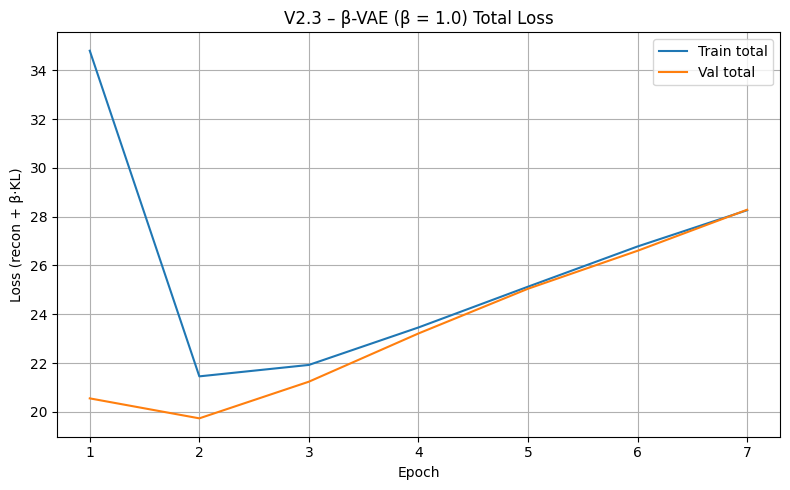

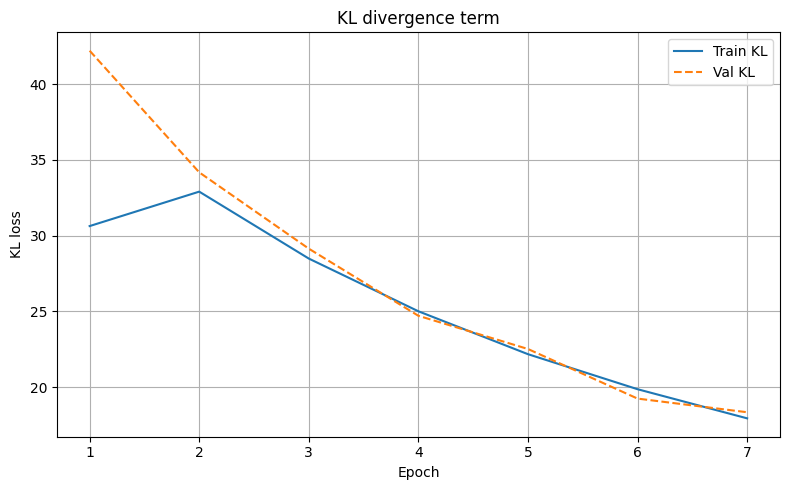

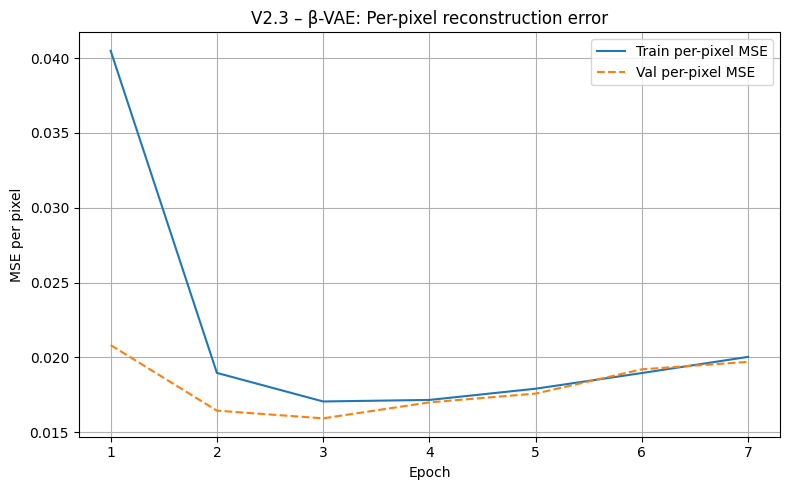

In [10]:
# ====== Cell 6: Plot Loss Curves (Train vs Validation) ======
# number of *completed* epochs (early stopping may stop before num_epochs)
n_epochs_done = len(train_total_losses)
epochs = np.arange(1, n_epochs_done + 1)

# --- 1) Total loss ---
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_total_losses, label="Train total")
plt.plot(epochs, val_total_losses,   label="Val total")
plt.xlabel("Epoch")
plt.ylabel("Loss (recon + β·KL)")
plt.title(f"V2.3 – β-VAE (β = {beta}) Total Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2) KL term ---
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_kl_losses, label="Train KL")
plt.plot(epochs, val_kl_losses,   label="Val KL", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("KL loss")
plt.title("KL divergence term")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3) (optional but nice) per-pixel recon MSE ---
train_recon_per_pixel = [loss / (28 * 28) for loss in train_recon_losses]
val_recon_per_pixel   = [loss / (28 * 28) for loss in val_recon_losses]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_recon_per_pixel, label="Train per-pixel MSE")
plt.plot(epochs, val_recon_per_pixel,   label="Val per-pixel MSE", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("MSE per pixel")
plt.title("V2.3 – β-VAE: Per-pixel reconstruction error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


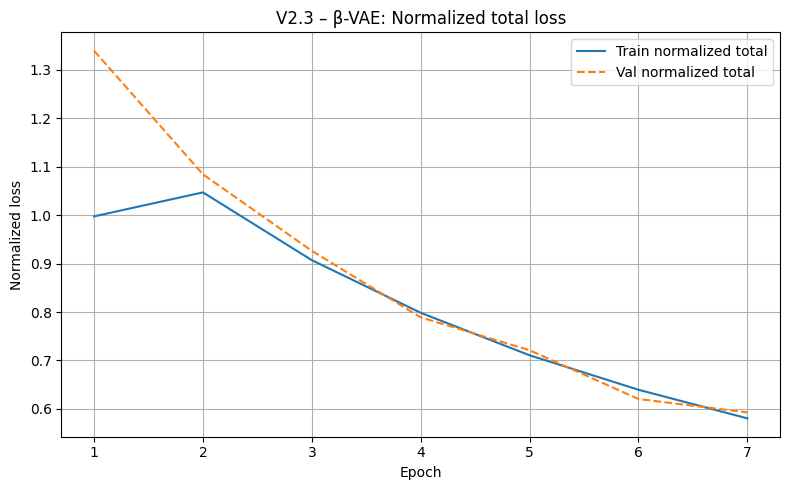

In [11]:
train_total_norm = []
val_total_norm   = []

for t_recon, t_kl, v_recon, v_kl in zip(
    train_recon_losses, train_kl_losses, val_recon_losses, val_kl_losses
):
    # per-pixel recon + KL scaled by latent dim
    tr = (t_recon / (28*28)) + (t_kl / 32)
    vr = (v_recon / (28*28)) + (v_kl / 32)
    train_total_norm.append(tr)
    val_total_norm.append(vr)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_total_norm, label="Train normalized total")
plt.plot(epochs, val_total_norm,   label="Val normalized total", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Normalized loss")
plt.title("V2.3 – β-VAE: Normalized total loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


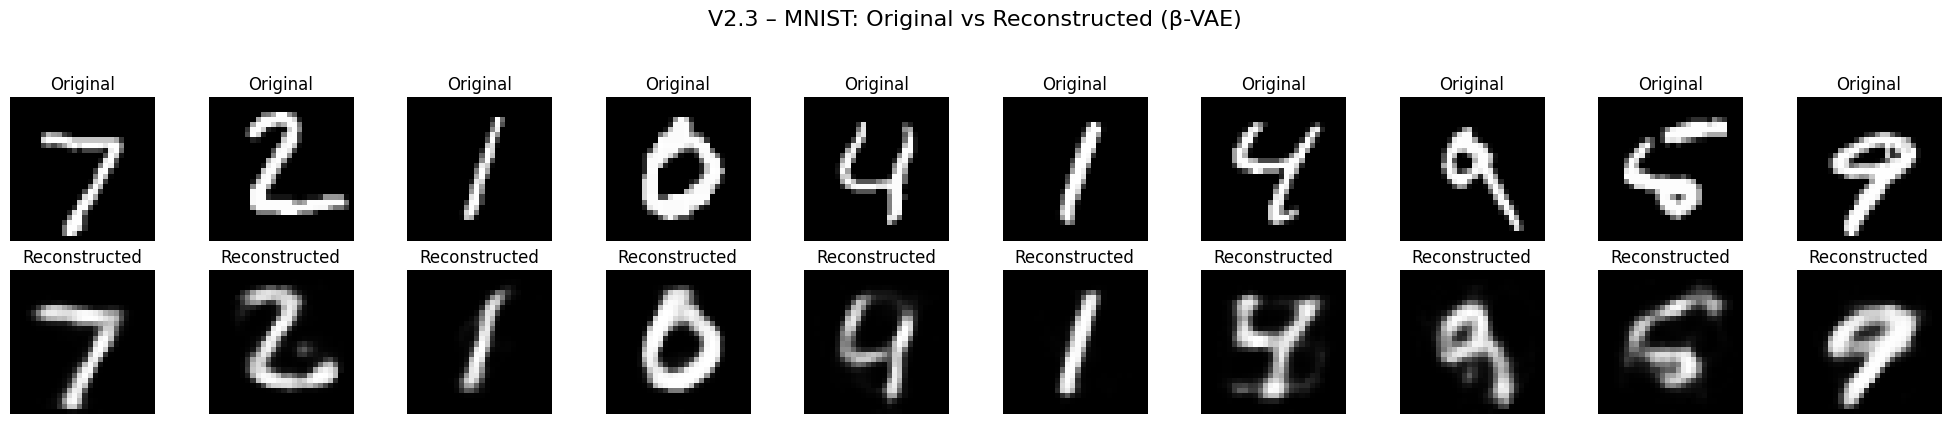

In [12]:
# ====== Cell 7: Original vs Reconstructed MNIST Test Images ======
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)
    recon, mu, logvar = model(images)

# Move to CPU for plotting
images_np = images.cpu().numpy()
recon_np  = recon.cpu().numpy()

n = 10  # number of examples to show
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images_np[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis("off")
    
    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_np[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")

plt.suptitle("V2.3 – MNIST: Original vs Reconstructed (β-VAE)", y=1.05, fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# ====== Cell 8: Save Model ======
torch.save(model.state_dict(), "autoencoder_mnist_v2_3.pth")
print("Model saved to autoencoder_mnist_v2_3.pth")


Model saved to autoencoder_mnist_v2_3.pth
